# _**Use yellowbricks library to get a vizual comparison of the feature weights in the learning process of landslide prediction**_

## Install and data loading

In [1]:
%%capture
!pip install -U yellowbrick

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Spectral_Indices.csv to Spectral_Indices (2).csv


In [3]:
import pandas as pd

In [4]:
# From Google Drive
df = pd.read_csv("/content/Spectral_Indices.csv")

In [5]:
df.describe()

,FID,pointid,B02_10m,B03_10m,B04_10m,B08_10m,B05_20m,B06_20m,B07_20m,B11_20m,B12_20m,SAVI,GNDVI,EVI2,EVI,REPO_20m,NDSI_20m,NDMI_20m,NDWI,BSI_20m,NDVI
count,916384.000000,916384.000000,916384.000000,916384.000000,916384.000000,916384.000000,916384.000000,916384.000000,916384.000000,916384.000000,916384.000000,916384.000000,916384.000000,916384.000000,916384.000000,916384.000000,916384.000000,916384.000000,916384.000000,916384.000000,916384.000000
mean,229160.772589,229161.772589,453.487733,678.985076,667.792126,2507.220471,1022.002313,1995.008541,2338.376351,1905.353363,1226.963447,0.889496,0.598084,1.494627,1.712308,716.254267,-0.526970,0.168937,-0.598084,-0.127655,0.622998
std,132381.700573,132381.700573,411.668652,528.489253,668.674479,782.668636,619.103003,588.486828,658.193021,869.381382,891.823996,0.387934,0.212355,0.651827,27.738560,160.144392,0.124603,0.185018,0.212355,0.189670,0.271713
min,0.000000,1.000000,1.000000,1.000000,1.000000,71.000000,33.000000,103.000000,154.000000,138.000000,33.000000,-0.519659,-0.478613,-0.873197,-9999.000000,-9999.000000,-0.997755,-0.513353,-0.998732,-0.654063,-0.363963
25%,114547.750000,114548.750000,185.000000,330.000000,202.000000,2066.000000,595.000000,1673.000000,1976.000000,1279.000000,564.000000,0.558085,0.444023,0.937779,0.872335,715.828000,-0.608636,-0.001879,-0.764370,-0.298190,0.390867
50%,229095.500000,229096.500000,274.000000,465.000000,315.000000,2462.000000,791.000000,1920.000000,2281.000000,1611.000000,810.000000,1.123660,0.699961,1.888060,2.075520,719.358000,-0.551370,0.240228,-0.699961,-0.203335,0.787026
75%,343643.250000,343644.250000,604.000000,887.000000,988.000000,2866.000000,1322.000000,2227.000000,2611.000000,2403.000000,1723.000000,1.216340,0.764370,2.043830,2.491540,721.352000,-0.470045,0.331723,-0.444023,0.059353,0.851921
max,465925.000000,465926.000000,7652.000000,10840.000000,13304.000000,15496.000000,10824.000000,13089.000000,14123.000000,13330.000000,13251.000000,1.426710,0.998732,2.397330,3735.000000,11260.000000,0.556232,0.802066,0.478613,0.434762,0.999257


# Data analytics

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer

# Create train and test dataset
target = "Class"
y = df[target]
X = df.drop([target, "FID"], axis=1)
features = list(X.columns)

# Normalized datatset and label encode
X_norm = MinMaxScaler().fit_transform(X)
y_encode = LabelBinarizer().fit_transform(y)

# # Create the training and test data
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_encode, shuffle=True, test_size=0.25, random_state=42)
n_features = X.shape[1]

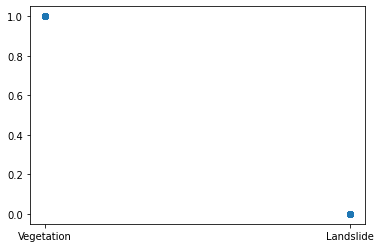

In [7]:
import matplotlib.pyplot as plt
plt.scatter(y, y_encode)

In [8]:
print("X_train :{}, y_train:{}, X_test:{}, y_test:{} \n for the features : {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape, features))

X_train :(687288, 20), y_train:(687288, 1), X_test:(229096, 20), y_test:(229096, 1) 
 for the features : ['pointid', 'B02_10m', 'B03_10m', 'B04_10m', 'B08_10m', 'B05_20m', 'B06_20m', 'B07_20m', 'B11_20m', 'B12_20m', 'SAVI', 'GNDVI', 'EVI2', 'EVI', 'REPO_20m', 'NDSI_20m', 'NDMI_20m', 'NDWI', 'BSI_20m', 'NDVI']


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


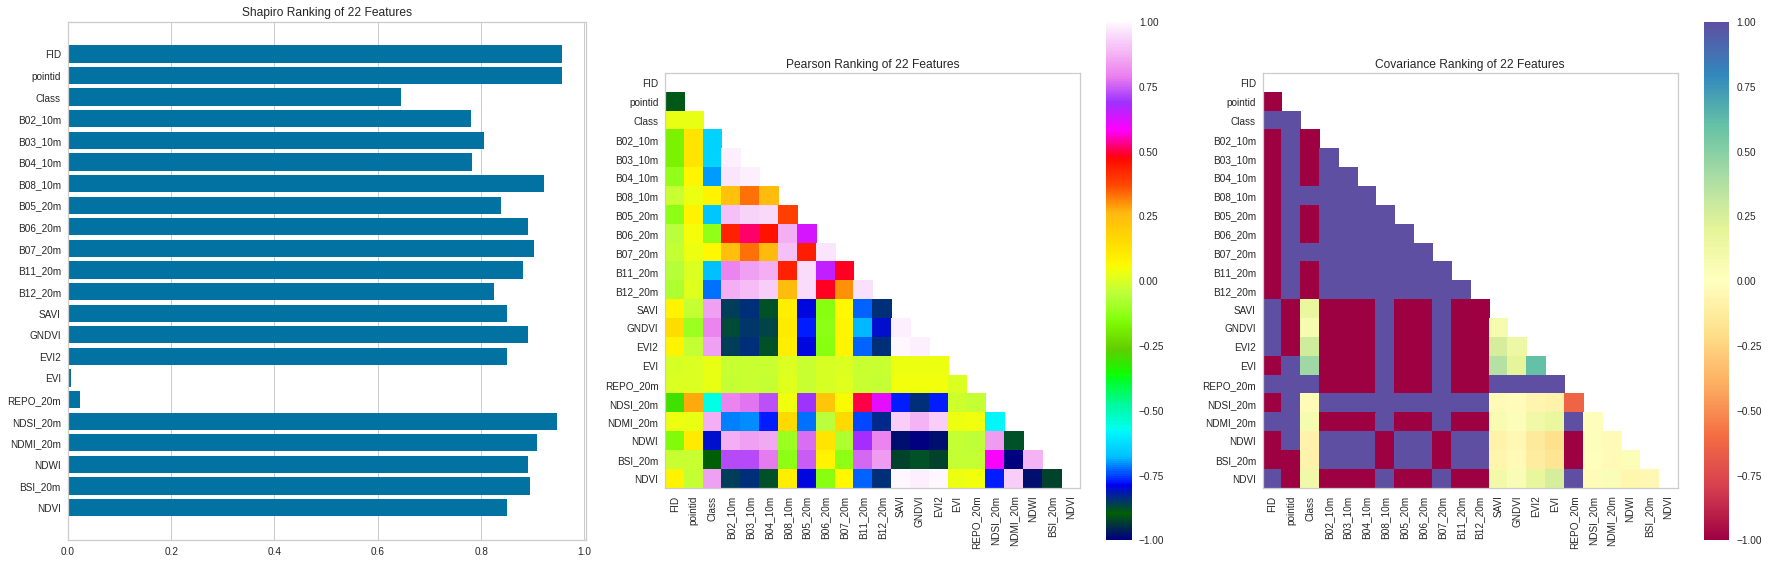

In [9]:
from yellowbrick.features import *
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=3, figsize=(25,8))

df["Class"] = y_encode

colormap = "gist_ncar"
rank1d(df, ax=axes[0], show=False, colormap=colormap) # https://www.spss-tutorials.com/spss-shapiro-wilk-test-for-normality/
rank2d(df, algorithm='pearson', ax=axes[1], show=False, colormap=colormap)
rank2d(df, algorithm='covariance', ax=axes[2], show=False, colormap="Spectral") # JOINT VARIABILITY - measure of how two random variables in a data set will change together;
                                                           # A positive covariance means that the two variables at hand are positively related, and they move in the same direction. 
                                                           # A negative covariance means that the variables are inversely related, or that they move in opposite directions.

plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Workfolder/Work_tech/sajag_nepal/Sindhupalchok_pilot_study/GIS_data/susceptibility/ML_parameters_weighting/data/output/pngs/data_correlations.png', dpi=300)
plt.show()

In [ ]:
fea = X_norm
tar = y_encode
classes = [0,1]
names = X.columns

radviz(fea, tar, classes=classes, features=names, colormap="bwr", alpha=0.2, show=False) # https://cran.r-project.org/web/packages/Radviz/vignettes/single_cell_projections.html


# Learning

In [ ]:
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


models = [ 
    LinearSVC(),
    # SGDClassifier(max_iter=100, tol=1e-3), 
    # KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs', max_iter=2000), 
    # LogisticRegressionCV(cv=3, max_iter=2000),
    # BaggingClassifier(), 
    # ExtraTreesClassifier(n_estimators=300),
    # GaussianNB(),
    RandomForestClassifier(n_estimators=300)
]


def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y) # useful???????

    model = Pipeline([
        ('one_hot_encoder', OneHotEncoder()),
        ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)

    expected  = y
    predicted = model.predict(X)

    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

for model in models:
    score_model(X, y, model)


LinearSVC: 0.7767878641945581
LogisticRegression: 0.3749187784275504
RandomForestClassifier: 1.0


In [ ]:
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve


# Create classifiers
lr = LogisticRegression(solver='lbfgs', max_iter=3000)
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=500)


# #############################################################################
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic Regression'),
                  (svc, 'Linear SVC'),
                  (rfc, 'Random Forest')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [ ]:
# test which features are the most important in the learning process
from sklearn.inspection import permutation_importance

model = RandomForestClassifier(n_estimators=500).fit(X_train, y_train)

r = permutation_importance(model, X_test, y_test,
                           n_repeats=10,
                           random_state=42)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print("{}: importances mean: {}; importance std: {}".format(features.columns[i], 
                                     r.importances_mean[i], 
                                     r.importances_std[i]))
        
        # print("{} -- {} --{}".format(features[i], 
        #                              r.importances_mean[i], 
        #                              r.importances_std[i]))

In [ ]:
# Instaniate the classification model and visualizer
import matplotlib.pyplot as plt
from yellowbrick.classifier import PrecisionRecallCurve

# !! model is inherited from previous cell

# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(model)
viz.fit(X_train, y_train)
viz.score(X_test.transpose(), y_test)
viz.show()

## Optimizers

In [ ]:
# # optimise ML
# !pip install scikit-optimize

In [ ]:
# # report scikit-optimize version number
# import skopt
# print('skopt %s' % skopt.__version__)

In [ ]:
# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer
# from skopt.plots import plot_objective, plot_histogram

# # pipeline class is used as estimator to enable
# # search over different model types
# pipe = Pipeline([
#     ('model', LinearSVC())
# ])

# # single categorical value of 'model' parameter is
# # sets the model class
# # We will get ConvergenceWarnings because the problem is not well-conditioned.
# # But that's fine, this is just an example.
# linsvc_search = {
#     'model': [LinearSVC(max_iter=1000)],
#     'model__C': (1e-6, 1e+6, 'log-uniform'),
# }

# # explicit dimension classes can be specified like this
# svc_search = {
#     'model': Categorical([SVC()]),
#     'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
#     'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
#     'model__degree': Integer(1,8),
#     'model__kernel': Categorical(['linear', 'poly', 'rbf']),
# }

# opt = BayesSearchCV(
#     pipe,
#     # (parameter space, # of evaluations)
#     [(svc_search, 40), (linsvc_search, 16)],
#     cv=3
# )

# opt.fit(X_train, y_train)

# print("val. score: %s" % opt.best_score_)
# print("test score: %s" % opt.score(X_test, y_test))
# print("best params: %s" % str(opt.best_params_))